In [0]:
from tqdm import tqdm
import pandas as pd
import pickle
import math
import random
import os
from pathlib import Path
from collections import defaultdict

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Hyperparameters for training
SEED = 42
TRAIN_FRAC = 0.95
MAX_BLOCK_SIZE = 512

LOGGING_STEPS = 100
EVAL_STEPS = 1000
TRAIN_BS = 4
EVAL_BS = 4
LR = 1e-4
EPOCHS = 1
GACCU_STEPS = 1
WARMUP_STEPS = 0

GENRES = ['Action', 'Adult', 'Adventure', 'Animation',
    'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
    'Fantasy', 'Game-Show', 'History', 'Horror', 'Lifestyle', 'Music',
    'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
    'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

In [0]:
# Dumps
NUM_SAMPLES_PER_GENRE = 10
# The temperature is “creativity” and allows the network to more likely make suboptimal predictions
TEMPS = [0.7, 1, 1.3]
# https://github.com/minimaxir/gpt-2-simple/issues/51
TOP_PS = [0, 0.9]

In [0]:
# Remember to define the model dir in GDrive for persistence if using Colab
MODEL_DIR = Path("drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-huggingface")
TRAIN_SCRIPT = MODEL_DIR/"run_lm_finetuning.py"
GENERATE_SCRIPT = MODEL_DIR/"run_generation.py"

# Prepared data
DATA_FILE = Path("drive/My Drive/Colab Notebooks/transformers/MoviePlots/data/data.pkl")

# Cache
# Our custom tokenizer with special tokens will be stored here
CACHE_DIR = MODEL_DIR/'cache'
CACHE_DIR.mkdir(exist_ok=True)
TOKENIZER_DIR = CACHE_DIR/"tokenizer"
TOKENIZER_DIR.mkdir(exist_ok=True)
# Inputs will be stored here
TRAIN_FILE = CACHE_DIR/'train.pkl'
TEST_FILE = CACHE_DIR/'test.pkl'

# Model checkpoints will be stored here
OUTPUT_DIR = MODEL_DIR/'output'
OUTPUT_DIR.mkdir(exist_ok=True)

# Logs for TensorBoard will be stored here
LOGS_DIR = MODEL_DIR/"logs"
LOGS_DIR.mkdir(exist_ok=True)

# Dumps will be stored here
DUMPS_DIR = MODEL_DIR/"dumps"
DUMPS_DIR.mkdir(exist_ok=True)

In [5]:
!ls "$MODEL_DIR"

cache  Evaluation.ipynb  output		    run_lm_finetuning.py
dumps  logs		 run_generation.py  Training.ipynb


## Import data

In [0]:
with open(DATA_FILE, 'rb') as handle:
    data = pickle.load(handle)

In [0]:
# Each plot has multiple genres
# But GPT-2 would learn more effectively if there was one-to-one relationship
# Two options: filter out plots with multiple genres, or duplicate them for each genre

def single_genre_augment(data):
    """For each plot with multiple genres, duplicate it for each genre."""
    augmented_data = []
    pbar = tqdm(total=len(GENRES)*len(data))
    for genre in GENRES:
        for d in data:
            if genre in d['genres']:
                single_genre_dict = dict(d)
                single_genre_dict['genre'] = genre
                augmented_data.append(single_genre_dict)
            pbar.update()
    pbar.close()
    return augmented_data

In [0]:
data = single_genre_augment(data)

print(len(data))

100%|██████████| 3281460/3281460 [00:02<00:00, 1146906.76it/s]

252490


## Tokenize data

In [7]:
!pip install transformers==2.1.1

     |████████████████████████████████| 317kB 6.5MB/s 
     |████████████████████████████████| 675kB 45.3MB/s 
     |████████████████████████████████| 1.0MB 44.2MB/s 
     |████████████████████████████████| 860kB 41.2MB/s 
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609189 sha256=647c8b940bde1567d00c606831ad9c8906b1c512c6e1f64e71bf3902b68356fd
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=ff8e0909f5e4f01729e7c8c6505fbb17fcece5d430a6afc0270de1808abb7630
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built regex sacremoses


In [8]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

100%|██████████| 456318/456318 [00:00<00:00, 1115310.51B/s]


In [7]:
# Add tokens
# We could just prepend genre labels as-is, it's all about convenience
# There is no '<|startoftext|>' since '<|endoftext|>' has the same meaning
EOG_TOKEN = '<|endofgenre|>'
EOT_TOKEN = '<|endoftitle|>'

special_tokens = [
    EOG_TOKEN,
    EOT_TOKEN
]
print(tokenizer.tokenize(''.join(special_tokens)))
tokenizer.add_tokens(special_tokens)
print(tokenizer.tokenize(''.join(special_tokens)))

['<', '|', 'end', 'of', 'genre', '|', '><', '|', 'end', 'oft', 'itle', '|', '>']
['<|endofgenre|>', '<|endoftitle|>']


In [0]:
# Save our custom tokenizer to disk
!rm -rf "$TOKENIZER_DIR"
!mkdir "$TOKENIZER_DIR"
tokenizer.save_pretrained(TOKENIZER_DIR)

In [0]:
!cat "$TOKENIZER_DIR"/added_tokens.json

{"<|endofgenre|>": 50257, "<|endoftitle|>": 50258}

In [0]:
def tokenize_example(example):
    """Process one example and tokenize for the use in GPT-2."""
    tokens = []
    # Encoding examples for Magic card text generator
    # https://github.com/minimaxir/mtg-gpt-2-cloud-run/blob/master/encoding_examples.txt

    tokens.extend(tokenizer.tokenize(example['genre'].lower()))
    tokens.append(EOG_TOKEN)
    tokens.extend(tokenizer.tokenize(example['title']))
    tokens.append(EOT_TOKEN)
    tokens.extend(tokenizer.tokenize(example['plot']))
    tokens.append(tokenizer.eos_token)

    return tokens

In [0]:
tokens = []
for example in tqdm(data):
    tokens.append(tokenize_example(example))

100%|██████████| 252490/252490 [02:56<00:00, 1429.46it/s]


In [0]:
print(data[0])
print(tokens[0])

{'title': '".hack//SIGN" (2002) {Intermezzo (#1.27)}', 'plot': " Bear joins Mimiru for an event held in the Dungeon of Nankoflak, a newly reopened dungeon known for giving rise to many a legend in the past. But Mimiru isn't there for the experience points or the treasure, but rather memories of one of her first experiences in The World, and the players she met there.", 'genres': {'Drama', 'Mystery', 'Animation', 'Action', 'Adventure', 'Sci-Fi', 'Thriller', 'Fantasy'}, 'year': 2002.0, 'episode': '1.27', 'primary': '.hack//SIGN', 'secondary': 'Intermezzo', 'genre': 'Action'}
['action', '<|endofgenre|>', '".', 'hack', '//', 'SIGN', '"', 'Ġ(', '2002', ')', 'Ġ{', 'Inter', 'me', 'zzo', 'Ġ(#', '1', '.', '27', ')}', '<|endoftitle|>', 'Bear', 'Ġjoins', 'ĠM', 'imir', 'u', 'Ġfor', 'Ġan', 'Ġevent', 'Ġheld', 'Ġin', 'Ġthe', 'ĠDungeon', 'Ġof', 'ĠN', 'ank', 'of', 'l', 'ak', ',', 'Ġa', 'Ġnewly', 'Ġreopened', 'Ġdungeon', 'Ġknown', 'Ġfor', 'Ġgiving', 'Ġrise', 'Ġto', 'Ġmany', 'Ġa', 'Ġlegend', 'Ġin', 'Ġthe

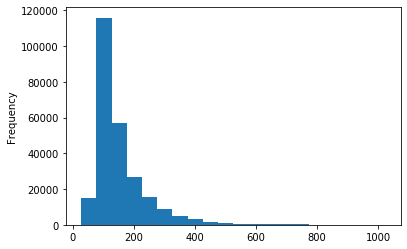

In [0]:
tokens_len_sr = pd.Series(tokens).apply(len)
tokens_len_sr = tokens_len_sr[tokens_len_sr <= 1024]
tokens_len_sr.plot.hist(bins=20)
# Derive the optimal block size from this plot

### Build inputs

In [0]:
def build_inputs(tokens):
    """Split tokens into equally-sized blocks and convert to inputs. No padding."""
    flat_tokens = [token for plot_tokens in tokens for token in plot_tokens]
    inputs = []
    # Truncate in block of MAX_BLOCK_SIZE
    # Note that we are losing the last truncated example here
    for i in tqdm(range(0, len(flat_tokens)-MAX_BLOCK_SIZE+1, MAX_BLOCK_SIZE)):
        block_tokens = flat_tokens[i:i+MAX_BLOCK_SIZE]
        block_tokens = tokenizer.convert_tokens_to_ids(block_tokens)
        # block_tokens = tokenizer.build_inputs_with_special_tokens(block_tokens)
        inputs.append(block_tokens)
    return inputs

In [0]:
inputs = build_inputs(tokens)

100%|██████████| 75587/75587 [00:38<00:00, 1974.60it/s]


In [0]:
pd.Series(inputs).apply(len).describe()

count    75587.0
mean       512.0
std          0.0
min        512.0
25%        512.0
50%        512.0
75%        512.0
max        512.0
dtype: float64

In [0]:
random.seed(SEED)
random.shuffle(inputs)

In [0]:
train_size = math.floor(TRAIN_FRAC * len(inputs))
train_inputs = inputs[:train_size]
test_inputs = inputs[train_size:]

In [0]:
# Save inputs to disk
with open(TRAIN_FILE, "wb") as handle:
    pickle.dump(train_inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(TEST_FILE, "wb") as handle:
    pickle.dump(test_inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Train model

In [9]:
!nvidia-smi

Fri Dec 13 14:36:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!python "$TRAIN_SCRIPT" \
    --output_dir="$OUTPUT_DIR" \
    --model_type=gpt2 \
    --model_name_or_path=gpt2 \
    --tokenizer_name_or_path="$TOKENIZER_DIR" \
    --do_train \
    --train_data_file="$TRAIN_FILE" \
    --log_dir="$LOGS_DIR" \
    --per_gpu_train_batch_size=$TRAIN_BS \
    --gradient_accumulation_steps=$GACCU_STEPS \
    --overwrite_output_dir \
    --seed=$SEED \
    --lr_finder

11/12/2019 00:18:28 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
11/12/2019 00:18:29 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
11/12/2019 00:18:29 - INFO - transformers.configuration_utils -   Model config {
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_

In [0]:
def plot_lr():
    """Plot loss against LR."""
    sr = pd.read_csv(OUTPUT_DIR/'lr_finder.txt', sep=',', header=None, squeeze=True, index_col=0)
    ax = sr.plot()
    print('lr:', sr.idxmin(), 'loss:', sr.min())
    ax.set_xscale('log')

lr: 0.05495408738576242 loss: 15.004688262939453


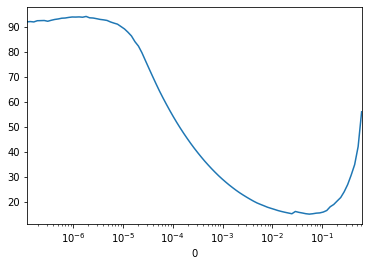

In [0]:
plot_lr()

# A good upper bound is not on the lowest point, but about a factor of 10 to the left.
# A good lower bound is the upper bound, divided by a factor 6.

In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir "$LOGS_DIR"

In [0]:
# Overfitting can be rectified by training for less time, or adding more input data. 
# Make sure to double check that your generated text is unique!

!python "$TRAIN_SCRIPT" \
    --output_dir="$OUTPUT_DIR" \
    --model_type=gpt2 \
    --model_name_or_path=gpt2 \
    --tokenizer_name_or_path="$TOKENIZER_DIR" \
    --do_train \
    --train_data_file="$TRAIN_FILE" \
    --log_dir="$LOGS_DIR" \
    --logging_steps=$LOGGING_STEPS \
    --per_gpu_train_batch_size=$TRAIN_BS \
    --per_gpu_eval_batch_size=$EVAL_BS \
    --gradient_accumulation_steps=$GACCU_STEPS \
    --learning_rate=$LR \
    --warmup_steps=$WARMUP_STEPS \
    --num_train_epochs=$EPOCHS \
    --do_eval \
    --eval_data_file="$TEST_FILE" \
    --evaluate_during_training \
    --eval_steps=$EVAL_STEPS \
    --overwrite_output_dir \
    --seed=$SEED

11/13/2019 22:43:33 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
11/13/2019 22:43:34 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
11/13/2019 22:43:34 - INFO - transformers.configuration_utils -   Model config {
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_

## Generate dumps

In [0]:
def generate_dump(prompt, num_samples, temp, top_p):
    """Generate a dump of samples.
    Inspired by https://github.com/minimaxir/hacker-news-gpt-2"""
    
    samples = !python "$GENERATE_SCRIPT" \
        --model_type=gpt2 \
        --model_name_or_path="$OUTPUT_DIR" \
        --prompt="$prompt" \
        --temperature=$temp \
        --top_p=$top_p \
        --num_samples=$num_samples \
        --length=256 \
        --stop_token=tokenizer.eos_token \
        --seed=$SEED
    return list(map(lambda x: prompt+x.split(tokenizer.eos_token)[0]+tokenizer.eos_token+'\n', samples[-num_samples:]))

In [11]:
generate_dump('horror' + EOG_TOKEN + 'Clown' + EOT_TOKEN, 10, 1, 0)

["horror<|endofgenre|>Clown<|endoftitle|>Clown has lost his pack. He uses the knowledge of the house to shape reality, making his own image then making his own. Now he's doing all he can to protect all the residents. He is an archaeologist and an important planner in clubgoing order, running up huge machines with the human abilities and location above theirs. Even though his father believes he's the greatest menace, Clown's master plan is a complete failure... Even stranger, the present people who have come to see him have all been programmed to cooperate with him. When a maniacous jewel thief kidnaps Clown and makes him useless as his guide, his only true friend in the whole cosmos, Clown fears he has lost something vital. Despite a nocturnal typhoon, the old man is rescued from a swimming pool and brought to life. The villagers claim to have seen a ghost as they wait for a shower... But when Clown finds a lone egg in his chest... will he be able to save it? Watch these 3 small childr

In [0]:
def save_dumps():
    """Generate dumps of samples and save them to disk."""
    pbar = tqdm(total=len(GENRES)*len(TEMPS)*len(TOP_PS), desc="Dumps")
    for temp in TEMPS:
        for top_p in TOP_PS:
            samples = []
            for genre in GENRES:
                prompt = genre.lower() + EOG_TOKEN
                samples.extend(generate_dump(prompt, NUM_SAMPLES_PER_GENRE, temp, top_p))
                pbar.update()
            fn = 'temp_%s_topp_%s.txt' % (str(temp).replace('.', '_'), str(top_p).replace('.', '_'))
            with open(DUMPS_DIR/fn, 'w') as f:
                f.writelines(samples)
    pbar.close()

In [10]:
save_dumps()

Dumps: 100%|██████████| 168/168 [2:07:51<00:00, 57.39s/it]


## References
- How GPT-2 works:
    - [The Illustrated GPT-2 (Visualizing Transformer Language Models)](http://jalammar.github.io/illustrated-gpt2/)
    - [TRANSFORMERS FROM SCRATCH](http://www.peterbloem.nl/blog/transformers)
- Practical applications:
    - [Code and UI for running a Magic card text generator API via GPT-2](https://github.com/minimaxir/mtg-gpt-2-cloud-run)
- Using Huggingface:
    - [Quick Start](https://huggingface.co/transformers/quickstart.html)
- Practical tips:
    - [How to fit GPT-2 into GPU](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255)
    - [Good default GPT-2 parameters](https://github.com/minimaxir/gpt-2-simple/blob/master/gpt_2_simple/gpt_2.py)
    - [Language model fine-tuning script](https://github.com/huggingface/transformers/blob/master/examples/run_lm_finetuning.py)
    - [Text generation script](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py)
    - [Optimizer Schedules](https://huggingface.co/transformers/main_classes/optimizer_schedules.html)
    - [What’s up with Deep Learning optimizers since Adam?](https://medium.com/vitalify-asia/whats-up-with-deep-learning-optimizers-since-adam-5c1d862b9db0)
    - [Adaptive - and Cyclical Learning Rates using PyTorch](https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee)
    - [The 1cycle policy](https://sgugger.github.io/the-1cycle-policy.html)